# Plasma Beta with FGM and FPI data

This notebook shows how to calculate plasma beta with FGM and FPI data

This command sets up the PySPEDAS environment when running in Google Colab.  You can skip it or comment it out if you're running this notebook in an environment that already has PySPEDAS installed.

In [ ]:
!pip install pyspedas

## Get started

In [1]:
from pyspedas.mms import fgm, fpi # load routines
from pyspedas import tinterpol # interpolate tplot variables
from pytplot import tplot, get_data, store_data # plot, access, and create tplot variables

## Define some constants

In [2]:
mu0 = 1256.0 # nT-m/A
Kb = 1.3807*10**(-16.) # cm^2-g-1/s^2-1/K

## Set some options for the load routines

In [3]:
probe = '1'
trange = ['2015-10-16/11:00', '2015-10-16/14:00']

## Load the FGM and FPI data

In [4]:
fgm_vars = fgm(trange=trange, probe=probe)
fpi_vars = fpi(datatype=['dis-moms', 'des-moms'], trange=trange, probe=probe, center_measurement=True)

08-Dec-23 11:08:14: Downloading mms1_fgm_srvy_l2_20151016_v4.18.0.cdf to pydata/mms1/fgm/srvy/l2/2015/10
08-Dec-23 11:09:02: Loaded variables:
08-Dec-23 11:09:02: Epoch
08-Dec-23 11:09:02: mms1_fgm_b_gse_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_b_gsm_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_b_dmpa_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_b_bcs_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_flag_srvy_l2
08-Dec-23 11:09:02: Epoch_state
08-Dec-23 11:09:02: mms1_fgm_hirange_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_bdeltahalf_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_stemp_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_etemp_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_mode_srvy_l2
08-Dec-23 11:09:02: mms1_fgm_b_dmpa_srvy_l2_bvec
08-Dec-23 11:09:02: mms1_fgm_b_dmpa_srvy_l2_btot
08-Dec-23 11:09:02: mms1_fgm_b_gse_srvy_l2_bvec
08-Dec-23 11:09:02: mms1_fgm_b_gse_srvy_l2_btot
08-Dec-23 11:09:02: mms1_fgm_b_gsm_srvy_l2_bvec
08-Dec-23 11:09:02: mms1_fgm_b_gsm_srvy_l2_btot
08-Dec-23 11:09:02: mms1_fgm_b_bcs_srvy_l2_bvec
08-Dec-23 11:09:02: mms1_

## Set some variable names

In [5]:
temp_para_i = 'mms'+probe+'_dis_temppara_fast'
temp_perp_i = 'mms'+probe+'_dis_tempperp_fast'
temp_para_e = 'mms'+probe+'_des_temppara_fast'
temp_perp_e = 'mms'+probe+'_des_tempperp_fast'
number_density_i = 'mms'+probe+'_dis_numberdensity_fast'
number_density_e = 'mms'+probe+'_des_numberdensity_fast'
b_field = 'mms'+probe+'_fgm_b_gsm_srvy_l2'
b_magnitude = 'mms'+probe+'_fgm_b_gsm_srvy_l2_mag'

## Split the B-field magnitude into its own variable

In [6]:
times, data = get_data(b_field)
store_data(b_magnitude, data={'x': times, 'y': data[:, 3]})

True

## Interpolate the B-field data to the FPI time stamps

In [7]:
tinterpol(b_magnitude, number_density_i, newname=['b_mag_interpolated'])

08-Dec-23 11:09:17: tinterpol (linear) was applied to: b_mag_interpolated


## Extract the data from the pyTplot variables

In [8]:
btimes, bdata = get_data('b_mag_interpolated')

ipatimes, i_para_temp = get_data(temp_para_i)
ipetimes, i_perp_temp = get_data(temp_perp_i)
epatimes, e_para_temp = get_data(temp_para_e)
epetimes, e_perp_temp = get_data(temp_perp_e)

nitimes, i_n = get_data(number_density_i)
netimes, e_n = get_data(number_density_e)

## Calculate the magnetic pressure

note: 1.0e-8 comes from A-nT/m -> g/(s^2-cm)

In [9]:
Pmag = 1.0e-8*bdata**2/(2.0*mu0)

## Calculate the ion and electron temperatures

In [10]:
Te_total=(e_para_temp+2*e_perp_temp)/3.0
Ti_total=(i_para_temp+2*i_perp_temp)/3.0

## Calculate the plasma pressure

note: eV -> K conversion: 11604.505 K/eV

In [11]:
Pplasma = (i_n*11604.505*Ti_total+e_n*11604.505*Te_total)*Kb

## Calculate plasma beta

In [12]:
Beta = Pplasma/Pmag

## Store the data in pyTplot variables

In [13]:
store_data('plasma_beta', data={'x': btimes, 'y': Beta})
store_data('magnetic_pressure', data={'x': btimes, 'y': Pmag})
store_data('plasma_pressure', data={'x': btimes, 'y': Pplasma})

True

## Plot the results

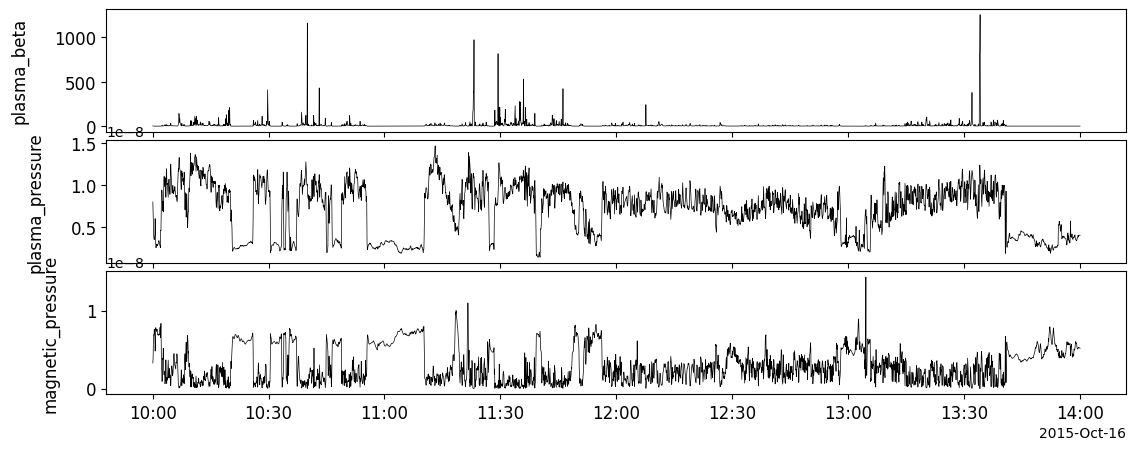

In [14]:
tplot(['plasma_beta', 'plasma_pressure', 'magnetic_pressure'])